# get most occuring vaccines

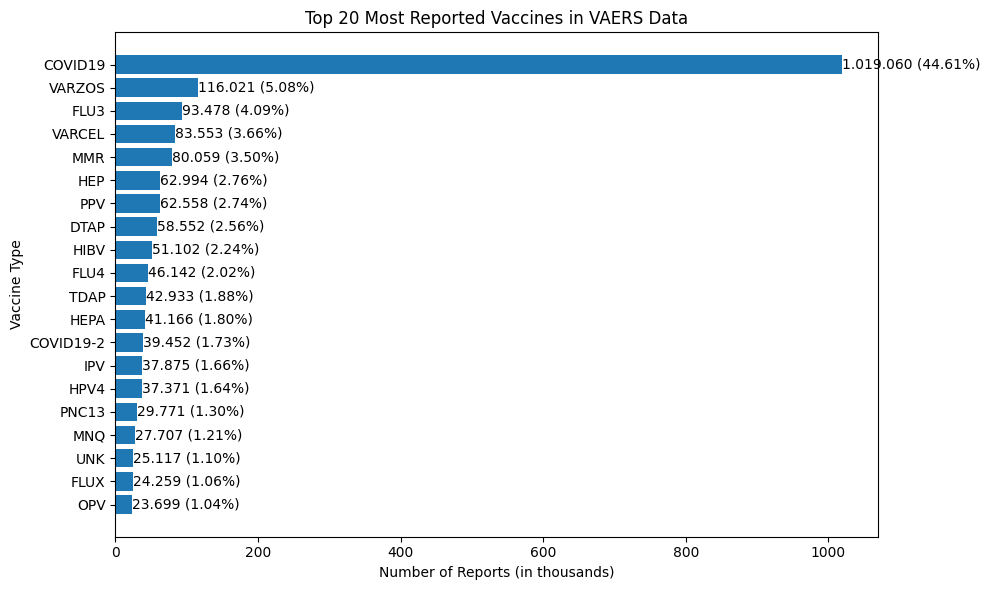

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming you have your datasets in a specified directory
base_path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"

vaccine_counts = pd.Series(dtype=int)

for year in range(1990, 2024):  # Adjust the years as per your data availability
    vax_file_path = f"{base_path}{year}VAERSVAX.csv"
    
    try:
        # Load vaccine data
        vax_df = pd.read_csv(vax_file_path, encoding='ISO-8859-1', usecols=['VAERS_ID', 'VAX_TYPE'])

        # Remove duplicate VAERS_ID and VAX_TYPE combinations
        
        # Count the occurrences of each vaccine type
        year_vaccine_counts = vax_df['VAX_TYPE'].value_counts()
        vaccine_counts = vaccine_counts.add(year_vaccine_counts, fill_value=0)

    except FileNotFoundError:
        print(f"File not found for year {year}.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Calculate total reports for percentage calculation
total_reports = vaccine_counts.sum()

# Sorting the vaccine counts
sorted_vaccine_counts = vaccine_counts.sort_values(ascending=False).head(20)  # Top 20 vaccine types

def thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_vaccine_counts.index, sorted_vaccine_counts.values)

plt.title('Top 20 Most Reported Vaccines in VAERS Data')
plt.xlabel('Number of Reports (in thousands)')
plt.ylabel('Vaccine Type')

# Set the formatter for the x-axis
plt.gca().xaxis.set_major_formatter(formatter)

# Adding the text inside the bars
for bar in bars:
    count = int(bar.get_width())
    percentage = (count / total_reports) * 100
    label = f'{count:,}'.replace(',', '.') + f' ({percentage:.2f}%)'
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, label, va='center', ha='left', color='black')

plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent vaccine at the top
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Vaccines/Top20VaccinesWithPercentage.png')
plt.show()



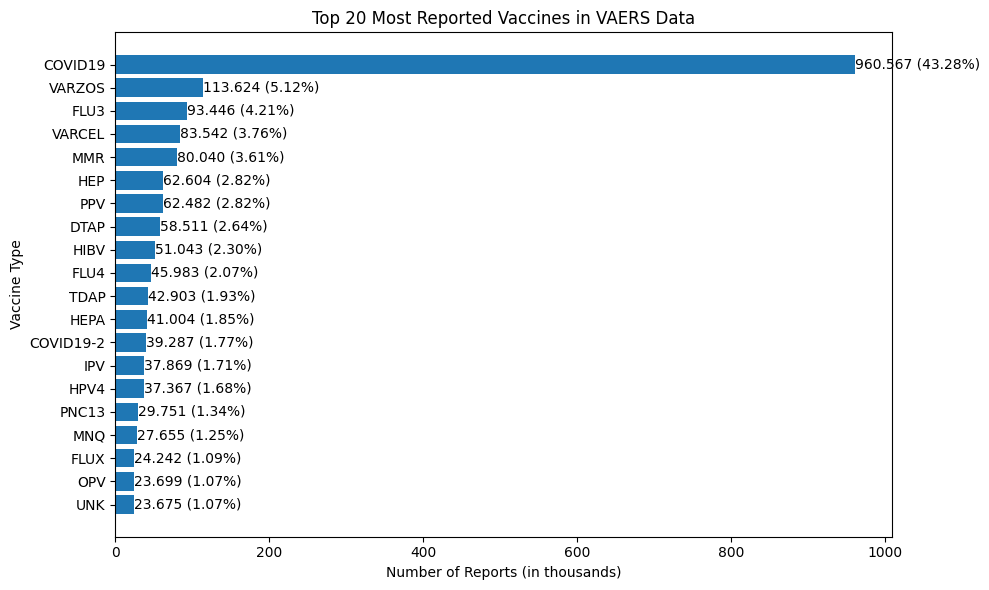

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming you have your datasets in a specified directory
base_path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"

vaccine_counts = pd.Series(dtype=int)

for year in range(1990, 2024):  # Adjust the years as per your data availability
    vax_file_path = f"{base_path}{year}VAERSVAX.csv"
    
    try:
        # Load vaccine data
        vax_df = pd.read_csv(vax_file_path, encoding='ISO-8859-1', usecols=['VAERS_ID', 'VAX_TYPE'])

        # Remove duplicate VAERS_ID and VAX_TYPE combinations
        vax_df = vax_df.drop_duplicates(subset=['VAERS_ID', 'VAX_TYPE'])
        
        # Count the occurrences of each vaccine type
        year_vaccine_counts = vax_df['VAX_TYPE'].value_counts()
        vaccine_counts = vaccine_counts.add(year_vaccine_counts, fill_value=0)

    except FileNotFoundError:
        print(f"File not found for year {year}.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Calculate total reports for percentage calculation
total_reports = vaccine_counts.sum()

# Sorting the vaccine counts
sorted_vaccine_counts = vaccine_counts.sort_values(ascending=False).head(20)  # Top 20 vaccine types

# Custom formatter for thousands
def thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_vaccine_counts.index, sorted_vaccine_counts.values)

plt.title('Top 20 Most Reported Vaccines in VAERS Data')
plt.xlabel('Number of Reports (in thousands)')
plt.ylabel('Vaccine Type')

# Set the formatter for the x-axis
plt.gca().xaxis.set_major_formatter(formatter)

# Adding the text inside the bars
for bar in bars:
    count = int(bar.get_width())
    percentage = (count / total_reports) * 100
    label = f'{count:,}'.replace(',', '.') + f' ({percentage:.2f}%)'
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, label, va='center', ha='left', color='black')

plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent vaccine at the top
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Vaccines/Top20VaccinesWithPercentage_NoDuplicates.png')
plt.show()
